[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tmollick95/iMapInvasives/blob/master/Code/Model%20training%20and%20validation%20code.ipynb)

### Mount Google Drive to access the dataset

In [6]:
#attach to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import necessary libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from io import BytesIO
import math
import json
from IPython.display import display, HTML

#### Change the current working directory

In [8]:
# Set the working directory
os.chdir("/content/drive/My Drive/iMapInvasives_datasets")

# Verify the current working directory
print("Current working directory:", os.getcwd())
os.listdir()

Current working directory: /content/drive/My Drive/iMapInvasives_datasets


['New_York_iMap_confirmed_records_from_year_2000.csv',
 'iMapInvasives_confirmed_reports',
 'USA_Shapefile',
 "Google StreetView iMap records'",
 'Output_Spotted_lanternfly_500_species_confirmed_records_using_VisionAPI.xlsx']

### Read csv file of New York State iMapInvasives confirmed records

#### The CSV file is in GitHub Dataset folder of iMapInvasives repository. To run this code download the CSV file and change the file path.

In [ ]:
ny = pd.read_csv("New_York_iMap_confirmed_records_from_year_2000.csv", encoding="ISO-8859-1")
ny.head()

,scientific,common_nam,observatio,number_fou,observer,species_ty,growth_hab,jurisdicti,county,regional_m,present_sp,habitat_ty,presence_i
0,Rosa multiflora,Multiflora Rose,12/11/2022,4,Elliott Adams,Plant,Shrub,New York,Montgomery,Capital Region,1327710,Terrestrial,1316659
1,Rosa lucieae (wichuraiana),Memorial Rose,7/1/2021,1,Steve Young,Plant,NaN,New York,Suffolk,LIISMA,1257468,Terrestrial,1249313
2,Lonicera spp (species unknown),Honeysuckle (species unknown),6/1/2023,0,Bethany Holland,Plant,Shrub,New York,Ontario,Finger Lakes,1393835,Terrestrial,1375738
3,Ailanthus altissima,"Tree-of-heaven, Ailanthus",7/15/2021,0,Brittany Hernon,Plant,Tree,New York,Erie,Western NY,1157922,Terrestrial,1151046
4,Amynthas-Metaphire spp. (species unknown),"Jumping Worms (species unknown), Asian jumping...",8/16/2021,0,Selma Rosenthal,Animal,NaN,New York,Onondaga,Finger Lakes,1166339,Terrestrial,1159257


### Fliter 500 Spotted Lanternfly Records

In [ ]:
# Filter records where jurisdicti is "New York"
ny_records = ny[ny['jurisdicti'] == 'New York']

# Further filter the records for "Alliaria petiolata"
alliaria_records = ny_records[ny_records['scientific'] == 'Lycorma delicatula']

# Check the available counties for this species in New York
available_counties = alliaria_records['county'].unique()
print(f"Available counties for Lycorma delicatula in New York: {available_counties}")

# Evenly distribute 500 records across all counties
num_counties = len(available_counties)
records_per_county = 500 // num_counties

# Sample records evenly across counties
sampled_records = alliaria_records.groupby('county').apply(lambda x: x.sample(n=min(len(x), records_per_county), replace=False))

# If we still need more records, sample remaining from counties that have more data
remaining_records_needed = 500 - len(sampled_records)

if remaining_records_needed > 0:
    extra_records = alliaria_records[~alliaria_records.index.isin(sampled_records.index)].sample(n=remaining_records_needed, replace=False)
    sampled_records = pd.concat([sampled_records, extra_records])

# Remove multi-index caused by groupby
sampled_records = sampled_records.reset_index(drop=True)

sampled_records.head()

Available counties for Lycorma delicatula in New York: ['Westchester' 'Suffolk' 'Nassau' 'Kings' 'Richmond' 'New York' 'Rockland'
 'Orange' 'Queens' 'Broome' 'Sullivan' 'Bronx' 'Ulster' 'Tioga' 'Seneca'
 'Dutchess' 'Erie' 'Putnam' 'Albany' 'Tompkins']


<ipython-input-5-41c384851b86>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_records = alliaria_records.groupby('county').apply(lambda x: x.sample(n=min(len(x), records_per_county), replace=False))


,scientific,common_nam,observatio,number_fou,observer,species_ty,growth_hab,jurisdicti,county,regional_m,present_sp,habitat_ty,presence_i
0,Lycorma delicatula,Spotted Lanternfly,8/29/2023,1,John Marino,Animal,Plant Pest,New York,Albany,Capital Region,1368225,Terrestrial,1350954
1,Lycorma delicatula,Spotted Lanternfly,8/21/2024,0,Sam Schultz,Animal,Plant Pest,New York,Albany,Capital Region,1455989,Terrestrial,1441530
2,Lycorma delicatula,Spotted Lanternfly,9/2/2023,0,Camille Caceci,Animal,Plant Pest,New York,Bronx,Lower Hudson,1369055,Terrestrial,1351709
3,Lycorma delicatula,Spotted Lanternfly,10/27/2022,0,Tom Abernathy,Animal,Plant Pest,New York,Bronx,Lower Hudson,1313593,Terrestrial,1303171
4,Lycorma delicatula,Spotted Lanternfly,8/25/2022,0,E L,Animal,Plant Pest,New York,Bronx,Lower Hudson,1299415,Terrestrial,1289311


### Request iMapInvasives API with run in Cookie based system
#### To get access to the iMap API please create account from https://www.imapinvasives.org/ website using email address and set a password.

In [ ]:
import requests

imap_site = "imapinvasives"
iMap_username = "iMap email address"  #Your iMap account email
iMap_password = "iMap password"  #Your iMap account password

login_url = r"https://{0}.natureserve.org/imap/j_spring_security_check".format(imap_site)

# Attempt to log in
print("\nAttempting to authenticate with: {0}".format(login_url))
iMapSession = requests.Session()  # This is a global variable accessed in later functions
login_response = iMapSession.post(login_url,{'j_username':iMap_username,'j_password':iMap_password})
login_response_message = "\nlogin response: {0}".format(login_response.status_code)
print(login_response_message)
login_response.raise_for_status()

# Attempt to access a record to check if log-in was successful
test_aoi_url = r"https://{0}.natureserve.org/imap/services/aoi/new".format(imap_site)
test_aoi_record = iMapSession.get(test_aoi_url)
test_aoi_record_message = "\nTest record access response: {0}".format(test_aoi_record.status_code)
print(test_aoi_record_message)

if test_aoi_record.status_code == 403:
    print("\nResponse Code 403 is most likely the result of an incorrectly entered iMap username or password.  It may also be caused by logging in as a user with insufficient permissions.")

test_aoi_record.raise_for_status()


Attempting to authenticate with: https://imapinvasives.natureserve.org/imap/j_spring_security_check

login response: 200

Test record access response: 200


### Filter iMap records which have photos uploaded by users

In [ ]:
# Read the presence IDs
record_ids = sampled_records
pre_ID = record_ids["presence_i"].tolist()  # Convert Series to list

In [ ]:
base_url = f"https://{imap_site}.natureserve.org/imap/services/presence/"

# List to store presence IDs with at least one species having a photo
presence_ids_with_photos = []

# Iterate over each presence ID
for presence_id in pre_ID:
    # Construct the full URL for each presence ID
    full_url = f"{base_url}{presence_id}"

    # Get the iMap record for this presence ID
    try:
        imap_record = iMapSession.get(full_url)  # Use the session to maintain authentication

        # Check if the request was successful
        if imap_record.status_code == 200:
            # Convert the response to a dictionary
            imap_dictionary = imap_record.json()

            # Extract all presentSpeciesId values from the speciesList
            present_species_ids = [species.get("presentSpeciesId") for species in imap_dictionary.get("speciesList", [])]

            # Filter out any None values just in case
            present_species_ids = [id for id in present_species_ids if id is not None]

            # Check if any presentSpeciesId has hasPhotoInd == True
            has_photo = any(species.get("hasPhotoInd") == True for species in imap_dictionary.get("speciesList", []))

            # If at least one presentSpeciesId has a photo, add the presence ID to the list
            if has_photo:
                presence_ids_with_photos.append(presence_id)

    except requests.exceptions.RequestException as e:
        print(f"An error occurred while processing presence ID {presence_id}: {e}")

In [ ]:
print(presence_ids_with_photos)

[1350954, 1441530, 1351709, 1303171, 1289311, 1163326, 1434907, 1158040, 1165050, 1355273, 1303110, 1251434, 1335779, 1355266, 1180108, 1160966, 1275483, 1272655, 1335780, 1164452, 1335781, 1308949, 1159069, 1153172, 1296965, 1275189, 1161144, 1442549, 1443955, 1363058, 1363331, 1281417, 1291538, 1412087, 1355577, 1416974, 1413837, 1363335, 1297821, 1442709, 1408723, 1249206, 1434302, 1294025, 1350316, 1352559, 1297435, 1158036, 1249202, 1163522, 1249216, 1272639, 1273356, 1272659, 1272654, 1272643, 1338828, 1273374, 1285448, 1273369, 1355280, 1159047, 1160795, 1335144, 1272649, 1160157, 1249203, 1272660, 1273903, 1249222, 1153641, 1163643, 1345668, 1338314, 1355027, 1343543, 1342729, 1305111, 1355056, 1355048, 1355155, 1341045, 1345672, 1343545, 1355161, 1335838, 1355058, 1291542, 1354836, 1434911, 1339831, 1351236, 1338306, 1290157, 1355052, 1338303, 1434892, 1160745, 1068482, 1153629, 1248781, 1160754, 1068492, 1163807, 1163960, 1162057, 1162982, 1164045, 1162969, 1163801, 1160753, 

In [ ]:
presence_ids = presence_ids_with_photos

### Function to extract the latitude and longitude from the iMap records

In [ ]:
import requests
import json
from PIL import Image
from io import BytesIO
import pandas as pd

# Function to extract latitude and longitude from the imap_dictionary
def get_lat_lon_from_imap(imap_dictionary):
    presence_point = imap_dictionary.get("presencePoint")
    if presence_point:
        return presence_point.get('latitude'), presence_point.get('longitude')

    presence_line = imap_dictionary.get("presenceLine")
    if presence_line:
        return presence_line.get('latitude'), presence_line.get('longitude')

    presence_polygon = imap_dictionary.get("presencePolygon")
    if presence_polygon:
        return presence_polygon.get('latitude'), presence_polygon.get('longitude')

    return None, None

### Function to reduce the image size in memory
#### iNaturalist VisionAPI can only accept the photo under 1 Megabyte for machine learning image recognition

In [ ]:
def reduce_image_size(image, max_size_kb=700):
    exif_data = image.info.get('exif')
    quality = 95
    while True:
        buffer = BytesIO()
        if exif_data:
            image.save(buffer, "JPEG", quality=quality, exif=exif_data)
        else:
            image.save(buffer, "JPEG", quality=quality)
        if buffer.tell() <= max_size_kb * 1024 or quality <= 10:
            return buffer
        quality -= 5

### Access iNaturalist VisionAPI as a Machine Learning image recogntion tool
#### Create an account in RapidAPI from this link https://rapidapi.com/ and subscribe for iNaturalist VisionAPI. By default free plan has a maximum of 200 image identification capacity per month. If you need more you can buy different subscription plan by payment. My premium plan is 2000 image processing power per month.
#### I am not sharing my RapidAPI key here. Replace it by your key after subscribe from RapidAPI.

In [ ]:
def identify_species(image_bytes, lat=None, lon=None):
    url = "https://visionapi.p.rapidapi.com/v1/rapidapi/score_image"
    headers = {
        "X-RapidAPI-Key": "RapidAPI Key",  # Replace with your RapidAPI key
        "X-RapidAPI-Host": "visionapi.p.rapidapi.com"
    }

    files = {'image': image_bytes}
    data = {}
    if lat is not None and lon is not None:
        data['lat'] = lat
        data['lng'] = lon

    response = requests.post(url, headers=headers, files=files, data=data)

    if response.status_code == 200:
        return response.json()
    else:
        return None

### Function to get the image from a URL, handling redirects and setting headers

In [ ]:
def get_image_from_url(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }

    response = requests.get(url, headers=headers, allow_redirects=True)

    if response.status_code == 200:
        try:
            return Image.open(BytesIO(response.content))
        except Exception as e:
            print(f"Failed to open image. Error: {e}")
            return None
    else:
        print(f"Failed to retrieve image. Status code: {response.status_code}")
        return None

### Function to process and identify species for all presentSpeciesId

In [ ]:
def process_species_images(imap_dictionary, base_url):
    data_rows = []
    species_list = imap_dictionary.get("speciesList", [])

    for species in species_list:
        photo_url = None
        present_species_id = species.get("presentSpeciesId")
        presence_id = species.get("presenceId")
        imap_sci = species.get("nationalSpeciesList", {}).get("scientificName", "Unknown")
        imap_com = species.get("nationalSpeciesList", {}).get("commonName", "Unknown")

        # Extract imap_record_taxon
        imap_record_taxon = species.get("nationalSpeciesList", {}).get("inaturalistTaxonId", "Unknown")

        # Prioritize photo URLs ending with '.jpg' or '.jpeg'
        potential_urls = []

        if "photos" in species and species["photos"]:
            potential_urls.append(species["photos"][0].get("photoUrl", ""))

        for url in potential_urls:
            if url and (url.lower().endswith('.jpg') or url.lower().endswith('.jpeg')):
                photo_url = url
                break

        if photo_url:
            img = get_image_from_url(photo_url)
            if img:
                resized_image_buffer = reduce_image_size(img, max_size_kb=700)
                lat, lon = get_lat_lon_from_imap(imap_dictionary)
                resized_image_buffer.seek(0)
                result = identify_species(resized_image_buffer, lat, lon)

                if result:
                    top_result = max(result["results"], key=lambda x: x["original_combined_score"])
                    inat_sci = top_result['taxon']['name']
                    inat_com = top_result['taxon'].get('preferred_common_name', 'Unknown').capitalize()
                    inat_taxon = top_result['taxon']['id']  # Extract inat_taxon
                    geo_score = round(top_result['original_geo_score'], 2)  # Extract geo_score
                    com_score = round(top_result['original_combined_score'], 2)
                    inatlink_html = f'=HYPERLINK("https://www.inaturalist.org/taxa/{inat_taxon}-{inat_sci.replace(" ", "-")}", "View")'
                else:
                    inat_sci = "Unknown"
                    inat_com = "Unknown"
                    inat_taxon = "Unknown"
                    geo_score = "Unknown"
                    com_score = "Unknown"
                    inatlink_html = "Unknown"
            else:
                photo_url = "No Photo"
                inat_sci = "Unknown"
                inat_com = "Unknown"
                inat_taxon = "Unknown"
                geo_score = "Unknown"
                com_score = "Unknown"
                inatlink_html = "Unknown"
        else:
            photo_url = "No Photo"
            inat_sci = "Unknown"
            inat_com = "Unknown"
            inat_taxon = "Unknown"
            geo_score = "Unknown"
            com_score = "Unknown"
            inatlink_html = "Unknown"

        # Check if imap_record_taxon and inat_taxon match, set species_label as 1 or 0
        if str(imap_record_taxon) == str(inat_taxon):
            species_label = 1
        else:
            species_label = 0


        # Construct imaplink only for the spreadsheet
        imaplink = f"https://imapinvasives.natureserve.org/imap/services/page/Presence/{presence_id}.html"
        imaplink_html = f'=HYPERLINK("{imaplink}", "View")'
        iMapPhoto_html = f'=HYPERLINK("{photo_url}", "View")' if photo_url != "No Photo" else "No Photo"

        # Add a row with all 17 columns (the last three are placeholders)
        row = [
            None, imaplink_html, presence_id, present_species_id,
            iMapPhoto_html, imap_sci, imap_com, imap_record_taxon, inatlink_html, inat_sci,
            inat_com, inat_taxon, geo_score, com_score, "", species_label, ""  # Adding placeholders for visual_model, species_label, and com_status
        ]
        data_rows.append(row)

    return data_rows

### Process all the input images from iMapInvasives

In [ ]:
def process_multiple_species_ids(presence_ids):
    base_url = "https://imapinvasives.natureserve.org/imap/services/presence/"  # Keeping the base URL unchanged for the API
    all_data = []

    for idx, presence_id in enumerate(presence_ids, start=1):
        print(f"\nProcessing presence ID: {presence_id}")
        full_url = f"{base_url}{presence_id}"

        imap_record = iMapSession.get(full_url)  # Using iMapSession to access the API

        if imap_record.status_code == 200:
            imap_dictionary = imap_record.json()
            data_rows = process_species_images(imap_dictionary, base_url)
            for row in data_rows:
                row[0] = idx  # Insert S.L. as the first column
                all_data.append(row)
        else:
            print(f"Failed to retrieve data for presence ID {presence_id}. Status code: {imap_record.status_code}")

    # Create DataFrame and save to Excel
    columns = [
        "S.L.", "imaplink", "presenceId", "presentSpeciesId", "iMapPhoto", "imap_sci",
        "imap_com", "imap_record_taxon", "inatlink", "inat_sci", "inat_com", "inat_taxon",
        "geo_score", "com_score", "visual_model", "species_label", "com_status"
    ]
    df = pd.DataFrame(all_data, columns=columns)

    # Save DataFrame to Excel file
    excel_file_name = "Output_Spotted_lanternfly_500_species_confirmed_records_using_VisionAPI.xlsx"
    df.to_excel(excel_file_name, index=False, engine='openpyxl')
    print(f"Data successfully exported to {excel_file_name}")

# Example usage: Replace presence_ids with your actual list of IDs
process_multiple_species_ids(presence_ids)

### Output from iNaturalist VisionAPI ML tool (Validation)

In [9]:
# File path to the Excel file
excel_file_name = "Output_Spotted_lanternfly_500_species_confirmed_records_using_VisionAPI.xlsx"

# Read the Excel file into a Pandas DataFrame
df = pd.read_excel(excel_file_name, engine='openpyxl')

# Display the first few rows of the DataFrame
df.head()

,S.L.,imaplink,presenceId,presentSpeciesId,iMapPhoto,imap_sci,imap_com,imap_record_taxon,inatlink,inat_sci,inat_com,inat_taxon,geo_score,com_score,visual_model,species_label,com_status
0,1,View,1350954,1368225,View,Lycorma delicatula,Spotted Lanternfly,324726,View,Halyomorpha halys,Brown marmorated stink bug,81923,31.59,25.49,NaN,0,NaN
1,2,View,1441530,1455989,View,Lycorma delicatula,Spotted Lanternfly,324726,View,Lycorma delicatula,Spotted lanternfly,324726,7.95,91.49,NaN,1,NaN
2,3,View,1180108,1187956,View,Lycorma delicatula,Spotted Lanternfly,324726,View,Lycorma delicatula,Spotted lanternfly,324726,81.28,99.96,NaN,1,NaN
3,4,View,1355266,1372898,View,Lycorma delicatula,Spotted Lanternfly,324726,View,Lycorma delicatula,Spotted lanternfly,324726,81.28,100,NaN,1,NaN
4,5,View,1303110,1313527,View,Lycorma delicatula,Spotted Lanternfly,324726,View,Lycorma delicatula,Spotted lanternfly,324726,81.28,99.74,NaN,1,NaN


In [11]:
# Get the unique values or names to see are there any other external species
unique_imap_sci = df['imap_sci'].unique()
print(unique_imap_sci)

['Lycorma delicatula' 'Ailanthus altissima']


In [14]:
#Get the unique values or names to see are there any records which don't have any photo uploaded by the users.
unique_iMapPhoto = df['iMapPhoto'].unique()
print(unique_iMapPhoto)

['View' 'No Photo']


In [16]:
# Filter the DataFrame to exclude rows
filtered_df = df[
    (df['iMapPhoto'] != 'No Photo') &
    (df['imap_sci'] != 'Ailanthus altissima')
]

# Display the filtered DataFrame
filtered_df.head()


,S.L.,imaplink,presenceId,presentSpeciesId,iMapPhoto,imap_sci,imap_com,imap_record_taxon,inatlink,inat_sci,inat_com,inat_taxon,geo_score,com_score,visual_model,species_label,com_status
0,1,View,1350954,1368225,View,Lycorma delicatula,Spotted Lanternfly,324726,View,Halyomorpha halys,Brown marmorated stink bug,81923,31.59,25.49,NaN,0,NaN
1,2,View,1441530,1455989,View,Lycorma delicatula,Spotted Lanternfly,324726,View,Lycorma delicatula,Spotted lanternfly,324726,7.95,91.49,NaN,1,NaN
2,3,View,1180108,1187956,View,Lycorma delicatula,Spotted Lanternfly,324726,View,Lycorma delicatula,Spotted lanternfly,324726,81.28,99.96,NaN,1,NaN
3,4,View,1355266,1372898,View,Lycorma delicatula,Spotted Lanternfly,324726,View,Lycorma delicatula,Spotted lanternfly,324726,81.28,100,NaN,1,NaN
4,5,View,1303110,1313527,View,Lycorma delicatula,Spotted Lanternfly,324726,View,Lycorma delicatula,Spotted lanternfly,324726,81.28,99.74,NaN,1,NaN


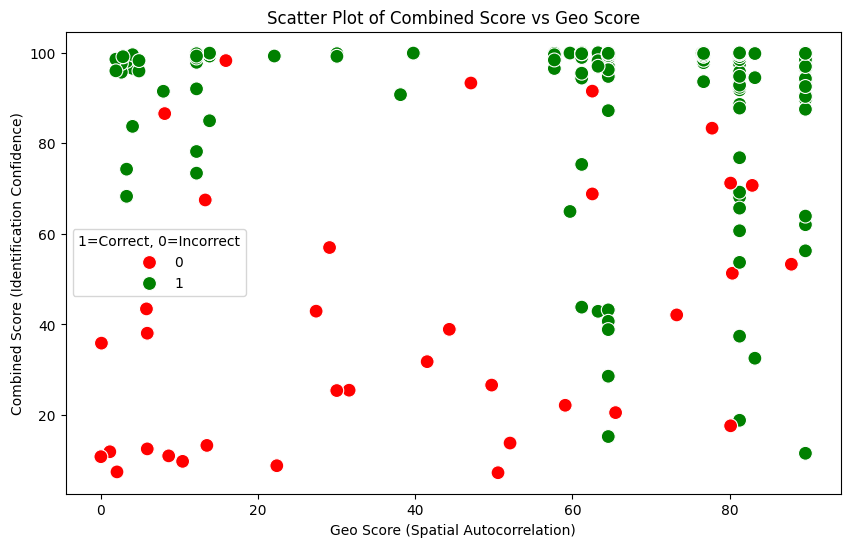

In [24]:
# Scatter plot: com_score vs. geo_score colored by species_label
plt.figure(figsize=(10, 6))
sns.scatterplot(data= filtered_df, x='geo_score', y='com_score', hue='species_label', palette={1: 'green', 0: 'red'}, s=100)
plt.title('Scatter Plot of Combined Score vs Geo Score')
plt.xlabel('Geo Score (Spatial Autocorrelation)')
plt.ylabel('Combined Score (Identification Confidence)')
plt.legend(title='1=Correct, 0=Incorrect')
plt.show()

The scatter plot demonstrates that high combined scores strongly correlate with correct species identifications, while low combined scores are linked to incorrect identifications. Geo score (spatial autocorrelation) adds context but is not a reliable standalone predictor of accuracy, as correct and incorrect identifications occur across a wide range of geo scores. In summary, combined score is the most critical factor in ensuring accurate species identification.

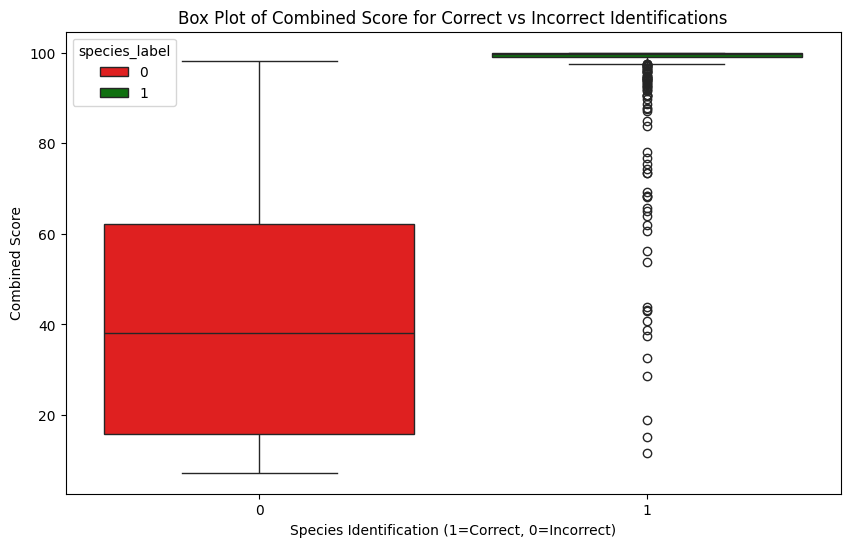

In [23]:
# Box plot: Comparing com_score distribution across correct and incorrect identifications
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=filtered_df,
    x='species_label',
    y='com_score',
    hue='species_label',  # Use 'species_label' for color distinction
    palette={1: 'green', 0: 'red'}  # Correctly map palette to the 'species_label' column
)
plt.title('Box Plot of Combined Score for Correct vs Incorrect Identifications')
plt.xlabel('Species Identification (1=Correct, 0=Incorrect)')
plt.ylabel('Combined Score')
plt.show()

The box plot reveals that correct species identifications consistently have high combined scores, clustering near 100, while incorrect identifications show a broader range with lower median scores. This highlights that a higher combined score is a strong indicator of correct identification, whereas lower scores are more likely to result in errors.

In [25]:
# Count the total number of records
total_records = len(filtered_df)

# Count the total number of correct and incorrect identifications
correct_count = filtered_df[filtered_df['species_label'] == 1].shape[0]
incorrect_count = filtered_df[filtered_df['species_label'] == 0].shape[0]

# Calculate percentages
correct_percentage = (correct_count / total_records) * 100
incorrect_percentage = (incorrect_count / total_records) * 100

# Print the results
print(f"Total Records: {total_records}")
print(f"Correct Identifications: {correct_count}")
print(f"Incorrect Identifications: {incorrect_count}")
print(f"Percentage of Correct Identifications: {correct_percentage:.2f}%")
print(f"Percentage of Incorrect Identifications: {incorrect_percentage:.2f}%")

Total Records: 498
Correct Identifications: 459
Incorrect Identifications: 39
Percentage of Correct Identifications: 92.17%
Percentage of Incorrect Identifications: 7.83%


Out of 498 total records, 459 (92.17%) were correctly identified, while 39 (7.83%) were incorrectly identified. This indicates a high accuracy in species identification.

### It is possible to get more than 99% accuracy of species identification by iNaturalist VisionAPI if the photo quality maintains the ML image recognition characteristics. As the iMapInvasives was developed for identification by manual review, there are many images that are not possible to identify by manual review. The reasons are:
  1. Photo taken from long distance
  2. The target is not focused
  3. The target is blur
  4. Orientation problems
  5. Multiple focused species within one image.
  6. Dried stems of plants or trees, etc